# Project 3


# Conversations Toxicity Detection

Jigsaw Unintended Bias in Toxicity Classification 

Detect toxicity across a diverse range of conversations


https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data#

# Sample Solution

### Install the Kaggle API and download the datasets

In [10]:
!pip install -U -q kaggle
!echo {"username":"albahnsen","key":"1c9e16f2c8e4de73bb6b7db12d17e22d"} > C:\Users\albah\.kaggle\kaggle.json

In [1]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -f test.csv -p ../datasets

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -f train.csv -p ../datasets

## Model with TF-IDF and Ranfom Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
import string
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
stop_words = set(stopwords.words('english'))
stem = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\albah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\albah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train_df = pd.read_csv("../datasets/train.csv.zip")
train_df = train_df[['id','comment_text', 'target']]
test_df = pd.read_csv("../datasets/test.csv.zip")

In [4]:
train_df.head()

,id,comment_text,target
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000
1,59849,Thank you!! This would make my life a lot less...,0.000000
2,59852,This is such an urgent design problem; kudos t...,0.000000
3,59855,Is this something I'll be able to install on m...,0.000000
4,59856,haha you guys are a bunch of losers.,0.893617


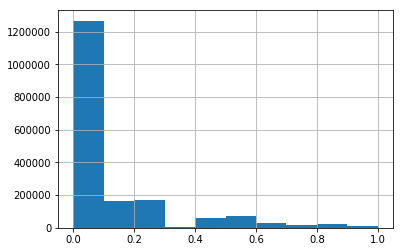

In [5]:
train_df.target.hist()

In [6]:
train_df.shape

(1804874, 3)

In [7]:
test_df.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [8]:
test_df.shape

(97320, 2)

In [9]:
train_df = train_df.sample(100000, random_state=42)

In [10]:
train_df.shape

(100000, 3)

Create tokens

In [11]:
def tokenize(text):
    
    tokens = []
    for token in word_tokenize(text):
        if token in string.punctuation: continue
        if token in stop_words: continue
        tokens.append(stem.stem(token))
    
    return " ".join(tokens)

In [12]:
train_tokens = Parallel(n_jobs=-1, verbose=1)(delayed(tokenize)(text) for text in train_df['comment_text'].tolist())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 8088 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 31088 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 63288 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 100000 out of 100000 | elapsed:   57.5s finished


In [13]:
train_tokens[0]

'what breath fresh air someon embrac common sens valu instead leadership canada clear differ page perhap read differ book'

In [14]:
test_tokens = Parallel(n_jobs=-1, verbose=1)(delayed(tokenize)(text) for text in test_df['comment_text'].tolist())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 9952 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 27452 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 51952 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 83452 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 97320 out of 97320 | elapsed:   50.8s finished


In [16]:
len(train_tokens + test_tokens)

197320

In [17]:
vect = TfidfVectorizer()
vect.fit(train_tokens + test_tokens)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [18]:
X = vect.transform(train_tokens)
y = train_df['target']

In [19]:
reg = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, max_depth=10)
reg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [20]:
test_X =  vect.transform(test_tokens)
test_y = reg.predict(test_X)